In [0]:
import re
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
# reading data
import pandas as pd

dataset = pd.read_csv('https://raw.githubusercontent.com/Riddhi9570/News-article-classification/main/News.csv', encoding='latin-1')
dataset.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [0]:
dataset.shape

(1490, 3)

In [0]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


In [0]:
dataset['Category'].value_counts()

sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64

In [0]:
# To see unique values in column "Category"
target_category = dataset['Category'].unique()
print(target_category)

['business' 'tech' 'politics' 'sport' 'entertainment']


In [0]:
# Represent Category names with numerical index and save it in a new column "CategoryId"
dataset['CategoryId'] = dataset['Category'].factorize()[0]
dataset.head()

,ArticleId,Text,Category,CategoryId
0,1833,worldcom ex-boss launches defence lawyers defe...,business,0
1,154,german business confidence slides german busin...,business,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,0
3,1976,lifestyle governs mobile choice faster bett...,tech,1
4,917,enron bosses in $168m payout eighteen former e...,business,0


In [0]:
# Create a new pandas dataframe "category", which only has unique categories, and sort this list in order of "CategoryId" values
category = dataset[['Category', 'CategoryId']].drop_duplicates().sort_values('CategoryId')
print(category)

        Category  CategoryId
0       business           0
3           tech           1
5       politics           2
6          sport           3
7  entertainment           4


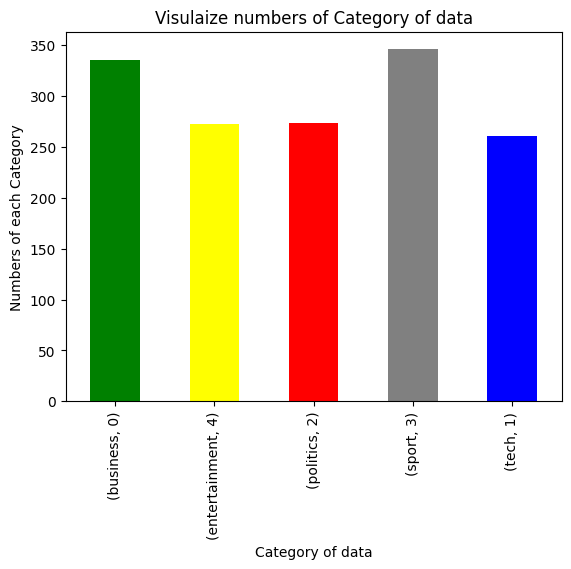

In [0]:
dataset.groupby('Category').CategoryId.value_counts().plot(kind = "bar", color = ["green", "yellow", "red", "grey", "blue"])
plt.xlabel("Category of data")
plt.ylabel("Numbers of each Category")
plt.title("Visulaize numbers of Category of data")
plt.show()

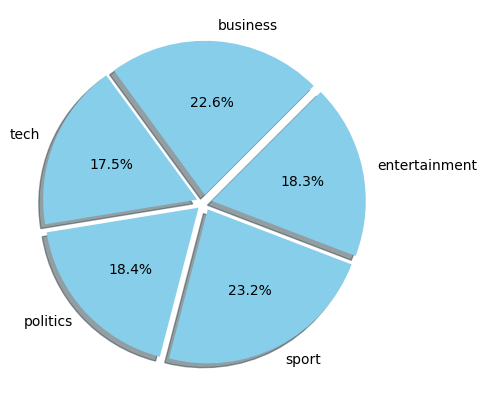

In [0]:
fig = plt.figure(figsize = (5,5))
colors = ["skyblue"]
business = dataset[dataset['CategoryId'] == 0 ]
tech = dataset[dataset['CategoryId'] == 1 ]
politics = dataset[dataset['CategoryId'] == 2]
sport = dataset[dataset['CategoryId'] == 3]
entertainment = dataset[dataset['CategoryId'] == 4]
count = [business['CategoryId'].count(), tech['CategoryId'].count(), politics['CategoryId'].count(), sport['CategoryId'].count(), entertainment['CategoryId'].count()]
pie = plt.pie(count, labels = ['business', 'tech', 'politics', 'sport', 'entertainment'],
              autopct = "%1.1f%%",
              shadow = True,
              colors = colors,
              startangle = 45,
              explode = (0.05, 0.05, 0.05, 0.05,0.05))

In [0]:
stop = set(stopwords.words('english'))
business = dataset[dataset['CategoryId'] == 0]
business = business['Text']
tech = dataset[dataset['CategoryId'] == 1]
tech = tech['Text']
politics = dataset[dataset['CategoryId'] == 2]
politics = politics['Text']
sport = dataset[dataset['CategoryId'] == 3]
sport = sport['Text']
entertainment = dataset[dataset['CategoryId'] == 4]
entertainment = entertainment['Text']

def wordcloud_draw(dataset, color = 'white'):
    words = ' '.join(dataset)
    cleaned_word = ' '.join([word for word in words.split()
    if (word != 'news' and word != 'text')])
    wordcloud = WordCloud(stopwords = stop, background_color = color,  width = 2500, height = 2500).generate(cleaned_word)
    plt.figure(1, figsize = (10,7))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

print("business related words:")
wordcloud_draw(business, 'white')
print("tech related words:")
wordcloud_draw(tech, 'white')
print("politics related words:")
wordcloud_draw(politics, 'white')
print("sport related words:")
wordcloud_draw(sport, 'white')
print("entertainment related words:")
wordcloud_draw(entertainment, 'white')

In [0]:
text = dataset["Text"]
text.head(15)

0     worldcom ex-boss launches defence lawyers defe...
1     german business confidence slides german busin...
2     bbc poll indicates economic gloom citizens in ...
3     lifestyle  governs mobile choice  faster  bett...
4     enron bosses in $168m payout eighteen former e...
5     howard  truanted to play snooker  conservative...
6     wales silent on grand slam talk rhys williams ...
7     french honour for director parker british film...
8     car giant hit by mercedes slump a slump in pro...
9     fockers fuel festive film chart comedy meet th...
10    blair rejects iraq advice calls tony blair has...
11    housewives lift channel 4 ratings the debut of...
12    uk coal plunges into deeper loss shares in uk ...
13    bp surges ahead on high oil price oil giant bp...
14    ireland 21-19 argentina an injury-time dropped...
Name: Text, dtype: object

In [0]:
category = dataset['Category']
category.head(15)

0          business
1          business
2          business
3              tech
4          business
5          politics
6             sport
7     entertainment
8          business
9     entertainment
10         politics
11    entertainment
12         business
13         business
14            sport
Name: Category, dtype: object

In [0]:
dataset['Text'][0]

'worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (Â£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by worldcom. mr eb

In [0]:
def remove_tags(text):
  remove = re.compile(r'<.*?>')
  return re.sub(remove, '', text)

dataset['Text'] = dataset['Text'].apply(remove_tags)
dataset['Text'][0]

'worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (Â£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by worldcom. mr eb

In [0]:
def special_char(text):
    reviews = ''
    for x in text:
        if x.isalnum():
            reviews = reviews + x
        else:
            reviews = reviews + ' '
    return reviews
dataset['Text'] = dataset['Text'].apply(special_char)
dataset['Text'][0]

'worldcom ex boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness   cynthia cooper  worldcom s ex head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002  her warnings led to the collapse of the firm following the discovery of an  11bn  Â 5 7bn  accounting fraud  mr ebbers has pleaded not guilty to charges of fraud and conspiracy   prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates  but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002  she said andersen had given a  green light  to the procedures and practices used by worldcom  mr eb

In [0]:
def convert_lower(text):
    return text.lower()
dataset['Text'] = dataset['Text'].apply(convert_lower)
dataset['Text'][0]

'worldcom ex boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness   cynthia cooper  worldcom s ex head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002  her warnings led to the collapse of the firm following the discovery of an  11bn  â 5 7bn  accounting fraud  mr ebbers has pleaded not guilty to charges of fraud and conspiracy   prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates  but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002  she said andersen had given a  green light  to the procedures and practices used by worldcom  mr eb

In [0]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    return [x for x in words if x not in stop_words]
dataset['Text'] = dataset['Text'].apply(remove_stopwords)
dataset['Text'][0]

['worldcom',
 'ex',
 'boss',
 'launches',
 'defence',
 'lawyers',
 'defending',
 'former',
 'worldcom',
 'chief',
 'bernie',
 'ebbers',
 'battery',
 'fraud',
 'charges',
 'called',
 'company',
 'whistleblower',
 'first',
 'witness',
 'cynthia',
 'cooper',
 'worldcom',
 'ex',
 'head',
 'internal',
 'accounting',
 'alerted',
 'directors',
 'irregular',
 'accounting',
 'practices',
 'us',
 'telecoms',
 'giant',
 '2002',
 'warnings',
 'led',
 'collapse',
 'firm',
 'following',
 'discovery',
 '11bn',
 'â',
 '5',
 '7bn',
 'accounting',
 'fraud',
 'mr',
 'ebbers',
 'pleaded',
 'guilty',
 'charges',
 'fraud',
 'conspiracy',
 'prosecution',
 'lawyers',
 'argued',
 'mr',
 'ebbers',
 'orchestrated',
 'series',
 'accounting',
 'tricks',
 'worldcom',
 'ordering',
 'employees',
 'hide',
 'expenses',
 'inflate',
 'revenues',
 'meet',
 'wall',
 'street',
 'earnings',
 'estimates',
 'ms',
 'cooper',
 'runs',
 'consulting',
 'business',
 'told',
 'jury',
 'new',
 'york',
 'wednesday',
 'external',
 'aud

In [0]:
import nltk
nltk.download('omw-1.4')

def lemmatize_word(text):
    wordnet = WordNetLemmatizer()
    return " ".join([wordnet.lemmatize(word) for word in text])
dataset['Text'] = dataset['Text'].apply(lemmatize_word)
dataset['Text'][0]

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


'worldcom ex bos launch defence lawyer defending former worldcom chief bernie ebbers battery fraud charge called company whistleblower first witness cynthia cooper worldcom ex head internal accounting alerted director irregular accounting practice u telecom giant 2002 warning led collapse firm following discovery 11bn â 5 7bn accounting fraud mr ebbers pleaded guilty charge fraud conspiracy prosecution lawyer argued mr ebbers orchestrated series accounting trick worldcom ordering employee hide expense inflate revenue meet wall street earnings estimate m cooper run consulting business told jury new york wednesday external auditor arthur andersen approved worldcom accounting early 2001 2002 said andersen given green light procedure practice used worldcom mr ebber lawyer said unaware fraud arguing auditor alert problem m cooper also said shareholder meeting mr ebbers often passed technical question company finance chief giving brief answer prosecution star witness former worldcom financia

In [0]:
x = dataset['Text']
y = dataset['CategoryId']

In [0]:
x = np.array(dataset.iloc[:,0].values)
y = np.array(dataset.CategoryId.values)

cv = CountVectorizer(max_features = 5000)
x = cv.fit_transform(dataset.Text).toarray()

print("X.shape = ",x.shape)
print("y.shape = ",y.shape)

X.shape =  (1490, 5000)
y.shape =  (1490,)


In [0]:
print("x:\n", x)
print("y:\n", y)

x:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
y:
 [0 0 0 ... 0 1 1]


In [0]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0, shuffle = True)

print(len(x_train))
print(len(x_test))

1043
447


In [0]:
print(x_train)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]


In [0]:
print(y_train)

[3 1 3 ... 4 0 1]


In [0]:
# Create list of model and accuracy dictionary
perform_list = [ ]

In [0]:
def run_model(model_name, est_c, est_pnlty):
    mdl = ""
    if model_name == 'Logistic Regression':
        mdl = LogisticRegression()
    elif model_name == 'Random Forest':
        mdl = RandomForestClassifier(n_estimators=100 ,criterion='entropy' , random_state=0)
    elif model_name == 'Multinomial Naive Bayes':
        mdl = MultinomialNB(alpha=1.0,fit_prior=True)
    elif model_name == 'Support Vector Classifer':
        mdl = SVC()
    elif model_name == 'Decision Tree Classifier':
        mdl = DecisionTreeClassifier()
    elif model_name == 'K Nearest Neighbour':
        mdl = KNeighborsClassifier(n_neighbors=10 , metric= 'minkowski' , p = 4)
    elif model_name == 'Gaussian Naive Bayes':
        mdl = GaussianNB()
    oneVsRest = OneVsRestClassifier(mdl)
    oneVsRest.fit(x_train, y_train)
    y_pred = oneVsRest.predict(x_test)
    
    # Performance metrics
    accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)
    
    # Get precision, recall, f1 scores
    precision, recall, f1score, support = score(y_test, y_pred, average='micro')
    print(f'Test Accuracy Score of Basic {model_name}: % {accuracy}')
    print(f'Precision : {precision}')
    print(f'Recall : {recall}')
    print(f'F1-score : {f1score}')
    
    # Add performance parameters to list
    perform_list.append(dict([('Model', model_name),('Test Accuracy', round(accuracy, 2)),('Precision', round(precision, 2)),('Recall', round(recall, 2)),('F1', round(f1score, 2))]))

In [0]:
run_model('Logistic Regression', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Logistic Regression: % 97.09
Precision : 0.970917225950783
Recall : 0.970917225950783
F1-score : 0.9709172259507831


In [0]:
run_model('Random Forest', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Random Forest: % 97.99
Precision : 0.9798657718120806
Recall : 0.9798657718120806
F1-score : 0.9798657718120806


In [0]:

run_model('Multinomial Naive Bayes', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Multinomial Naive Bayes: % 97.09
Precision : 0.970917225950783
Recall : 0.970917225950783
F1-score : 0.9709172259507831


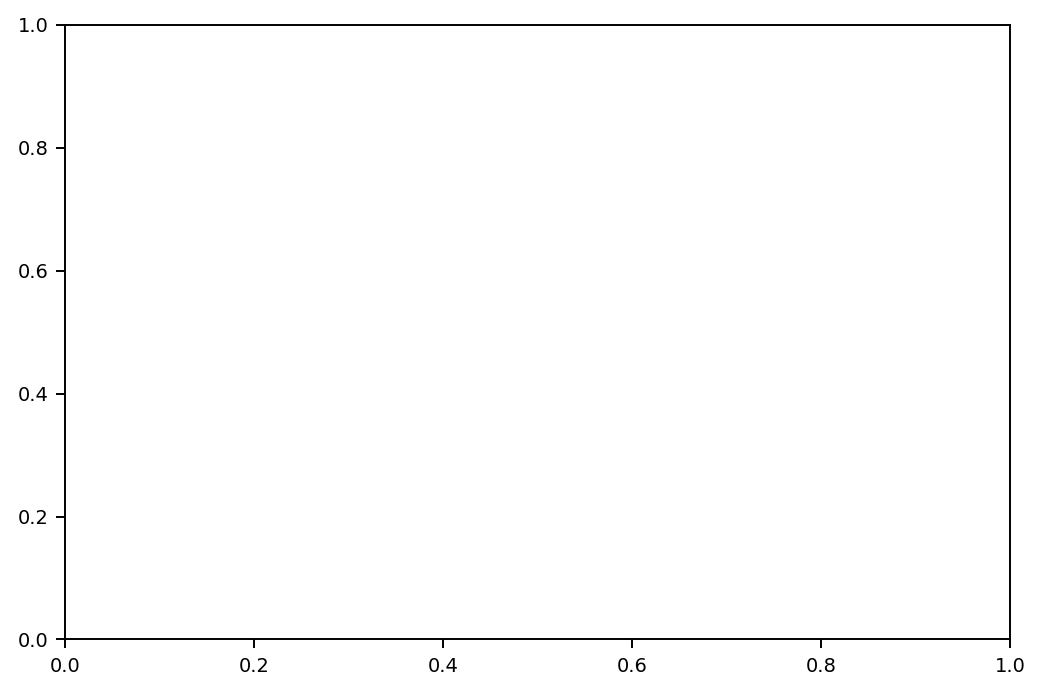

Test Accuracy Score of Basic Support Vector Classifer: % 96.64
Precision : 0.9664429530201343
Recall : 0.9664429530201343
F1-score : 0.9664429530201343


In [0]:
run_model('Support Vector Classifer', est_c=None, est_pnlty=None)

In [0]:
run_model('Decision Tree Classifier', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Decision Tree Classifier: % 83.89
Precision : 0.8389261744966443
Recall : 0.8389261744966443
F1-score : 0.8389261744966443


In [0]:
run_model('Gaussian Naive Bayes', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Gaussian Naive Bayes: % 76.06
Precision : 0.7606263982102909
Recall : 0.7606263982102909
F1-score : 0.7606263982102909


In [0]:
model_performance = pd.DataFrame(data=perform_list)
model_performance = model_performance[['Model', 'Test Accuracy', 'Precision', 'Recall', 'F1']]
model_performance

,Model,Test Accuracy,Precision,Recall,F1
0,Logistic Regression,97.09,0.97,0.97,0.97
1,Random Forest,97.99,0.98,0.98,0.98
2,Multinomial Naive Bayes,97.09,0.97,0.97,0.97
3,Support Vector Classifer,96.64,0.97,0.97,0.97
4,Decision Tree Classifier,83.89,0.84,0.84,0.84
5,Gaussian Naive Bayes,76.06,0.76,0.76,0.76


In [0]:
classifier = RandomForestClassifier(n_estimators=100 ,criterion='entropy' , random_state=0).fit(x_train, y_train)

y_pred = classifier.predict(x_test)

In [0]:
y_pred1 = cv.transform(['Hour ago, I contemplated retirement for a lot of reasons. I felt like people were not sensitive enough to my injuries. I felt like a lot of people were backed, why not me? I have done no less. I have won a lot of games for the team, and I am not feeling backed, said Ashwin'])
yy = classifier.predict(y_pred1)
result = ""
if yy == [0]:
    result = "Business News"
elif yy == [1]:
    result = "Tech News"
elif yy == [2]:
    result = "Politics News"
elif yy == [3]:
    result = "Sports News"
elif yy == [1]:
    result = "Entertainment News"
    
print(result)

Sports News
